In [1]:
%load_ext autoreload
%autoreload 2

## Learning a classifier

On commence par la fonction de base apprise de la librairie torch, cf https://raw.githubusercontent.com/pytorch/examples/master/mnist/main.py :

In [2]:
%run what.py --epochs 0

In [3]:
%whos

Variable         Type        Data/Info
--------------------------------------
F                module      <module 'torch.nn.functio<...>/torch/nn/functional.py'>
Net              type        <class '__main__.Net'>
argparse         module      <module 'argparse' from '<...>b/python3.7/argparse.py'>
datasets         module      <module 'torchvision.data<...>on/datasets/__init__.py'>
main             function    <function main at 0x1114cef28>
nn               module      <module 'torch.nn' from '<...>es/torch/nn/__init__.py'>
optim            module      <module 'torch.optim' fro<...>torch/optim/__init__.py'>
print_function   _Feature    _Feature((2, 6, 0, 'alpha<...>0, 0, 'alpha', 0), 65536)
test             function    <function test at 0x1114ceea0>
torch            module      <module 'torch' from '/us<...>kages/torch/__init__.py'>
train            function    <function train at 0x10bb02488>
transforms       module      <module 'torchvision.tran<...>/transforms/__init__.py'>


In [4]:
from what import Net
model = Net()


On apprend une matrice de poids qui est fixée dans la suite et que nous allons utiliser pour la classification

In [5]:
%ls -ltr ../data/mnist_cnn.pt
#%rm -f ../data/mnist_cnn.pt

-rw-r--r--  1 laurentperrinet  staff  1725644 Mar  7 10:35 ../data/mnist_cnn.pt


In [6]:
model_path = "../data/mnist_cnn.pt"

import os
if os.path.isfile(model_path):
    print('Loading')
    model.load_state_dict(torch.load(model_path))
else:
    print('Learning')
    import time
    t0 = time.time()
    %run what.py --epochs 10 --save-model
    print('Done in ', time.time() - t0, 'seconds')

Loading


## Using the learned classifier in a standalone class

Maintenant qu'on a appris les points qui permet une classification d'à peu près 98 % on va utiliser le modèle fead-forward pour faire la classification.

In [7]:
class Args:
    def __init__(self):
        log_interval = 100
args = Args()
        

In [8]:
from retina import get_data_loader

test_loader = get_data_loader(batch_size=1000, train=False)

In [9]:
model = Net()
model.load_state_dict(torch.load(model_path))
from what import test
accuracy = test(args, model, torch.device("cpu"), test_loader)
print('accuracy=', accuracy)


Test set: Average loss: 0.0322, Accuracy: 9894/10000 (99%)

accuracy= 0.9894


## shifting the input images


Je vais maintenant générer des données en utilisant les données originales de MNIST translatées :

In [10]:

from torchvision import datasets, transforms
i_shift, j_shift = 12, 17
N_pix = 28


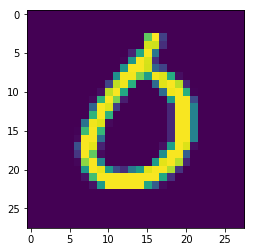

In [11]:
%matplotlib inline
for data, target in test_loader:
    break
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.imshow(data[0, 0, :, :])

In [12]:
import numpy as np
data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 2, N_pix*3 - 2))
print(data_translate.shape)
data_translate[:, :, (N_pix-i_shift):(2*N_pix-i_shift), (N_pix-j_shift):(2*N_pix-j_shift)] = data
fig, ax = plt.subplots()
ax.imshow(data_translate[0, 0, :, :])

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3291, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-257c5e457514>", line 2, in <module>
    data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 2, N_pix*3 - 2))
TypeError: mul(): argument 'other' (position 1) must be Tensor, not numpy.ndarray

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2033, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'TypeError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/site-packages/IPython/core/ultratb.py", line 1095, in get_records
    return _fixed_getinnerframes(etb, number_

TypeError: mul(): argument 'other' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

In [ ]:
np.arange(-N_pix+1, N_pix)

In [ ]:
def shift_data(data, i_shift, j_shift):
    N_pix = data.shape[-1]
    assert(N_pix == data.shape[-2])
    import numpy as np
    data_translate = data.min() * np.ones((data.shape[0], 1, N_pix*3 - 1, N_pix*3 - 1))
    data_translate[:, :, (N_pix+i_shift):(2*N_pix+i_shift), (N_pix+j_shift):(2*N_pix+j_shift)] = data
    data_cropped = data_translate[:, :, (N_pix):(2*N_pix), (N_pix):(2*N_pix)]
    return data_cropped

data_cropped = shift_data(data, i_shift = 12, j_shift = -12)
fig, ax = plt.subplots()
ax.imshow(data_cropped[0, 0, :, :])

## Using the learned classifier on the shifted data

On peut maintenant tester le classifieur sur les images Translatées en calculant la valeur de classification en  fonction de l'erreur de localisation

In [ ]:
def test_shift(test_loader, i_shift, j_shift, verbose=0):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data_cropped = shift_data(data, i_shift=i_shift, j_shift=j_shift)        
        data_cropped = torch.FloatTensor(data_cropped) #transforms.ToTensor()(data_cropped)
        data_cropped, target = Variable(data_cropped, volatile=True), Variable(target)
        output = model(data_cropped)
        test_loss += F.nll_loss(output, target, size_average=False).data[0] # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader.dataset)
    if verbose: print('\nTest set: at ({}, {}), the  average loss is {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        i_shift, j_shift, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)


path = "MNIST_accuracy.npy"

import os
if os.path.isfile(path):
    print('Loading accuracy')
    accuracy = np.load(path)
else:
    print('Computing accuracy')
    import time
    t0 = time.time()
    accuracy = np.zeros((2*N_pix-1, 2*N_pix-1))
    from tqdm import tqdm
    N_step = 1

    with tqdm(total=(2*N_pix-1)**2/N_step**2) as pbar:
        for i_shift in np.arange(-N_pix+1, N_pix, N_step):
            for j_shift in np.arange(-N_pix+1, N_pix, N_step):
                accuracy[i_shift+N_pix-1, j_shift+N_pix-1] = test_shift(test_loader, i_shift, j_shift)
                pbar.update()
    np.save(path, accuracy)
    print('Done in ', time.time() - t0, 'seconds')
    
print('accuracy=', accuracy)    

J'avoue que c'est un peu bourrin de calculer la classification sur les 128 × 128 pixels pour 1000 batch multiplié par 10 type d'entrées.... Mais bon on doit faire ça seulement une fois :-) (et sur CPU une classif = environ 300µs ...)

In [ ]:
fig, ax = plt.subplots(figsize=(13, 10.725))
cmap = ax.pcolor(np.arange(-N_pix+1, N_pix+1), np.arange(-N_pix+1, N_pix+1), accuracy)
ax.axis('equal')
fig.colorbar(cmap)

Cette fonction de performance du classifieur  est calculée indépendamment de la forme spécifique du chiffre entre 0 et 9. Elle donne donc la carte de performance qu'on attend Au niveau de la classification/ On va pouvoir maintenant l'utiliser ceomm label pour apprendre de façon supervisée la correspondance entre la carte log-polaire obtenue depuis l'image brute et cette carte de performance.


# Retinotopic mapping

#### Orientation invariant power encoding (colliculus??)

In [ ]:
colliculus = (retina_transform**2).sum(axis=(0, 3))
#colliculus = colliculus**.5
colliculus /= colliculus.sum(axis=-1)[:, :, None]
print(colliculus.shape)

In [ ]:
colliculus_vector = colliculus.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
print(colliculus_vector.shape)

In [ ]:
colliculus_inverse = np.linalg.pinv(colliculus_vector)
print(colliculus_inverse.shape)

In [ ]:
energy = (retina**2).sum(axis=(0,3)) 
energy /= energy.sum(axis=-1)[:, :, None]
energy_vector = energy.reshape((N_azimuth*N_eccentricity, N_X*N_Y))
energy_plus = np.linalg.pinv(energy_vector)
FIG_WIDTH = 5 

fig, ax = plt.subplots(figsize=(FIG_WIDTH, FIG_WIDTH))
for i_orient in range(N_azimuth):
    for i_scale in range(N_eccentricity):
        env = np.sqrt(energy[i_orient, i_scale, :]**2.5).reshape((N_X, N_Y))
        ax.contour(energy[i_orient, i_scale, :].reshape((N_X, N_Y)), levels=[env.max()/2], lw=1,
                  colors=[plt.cm.rainbow(i_scale * 1.5/N_azimuth)])
fig.suptitle('Tiling of visual space using energy', y=1.02)
ax.set_xlabel(r'$Y$')
ax.set_ylabel(r'$X$')
ax.axis('equal')
plt.tight_layout()